In [ ]:
!pip install contractions
!pip install imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 10.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import contractions
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
import joblib
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
#from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
df=pd.read_csv("fake_job_postings.csv")
df

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
17878,17879,Graphic Designer,"NG, LA, Lagos",NaN,NaN,NaN,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0


# Data Exploration & Cleaning

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [ ]:
# Drop the 'job_id' column
df = df.drop(columns=['job_id'])

In [ ]:
df.shape

(17880, 17)

In [ ]:
df.describe()

,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000
mean,0.042897,0.795302,0.491723,0.048434
std,0.202631,0.403492,0.499945,0.214688
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


To find out if there is duplication

In [ ]:
df.duplicated().sum()

281

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.duplicated().sum()

0

To find out how many null data

<Axes: >

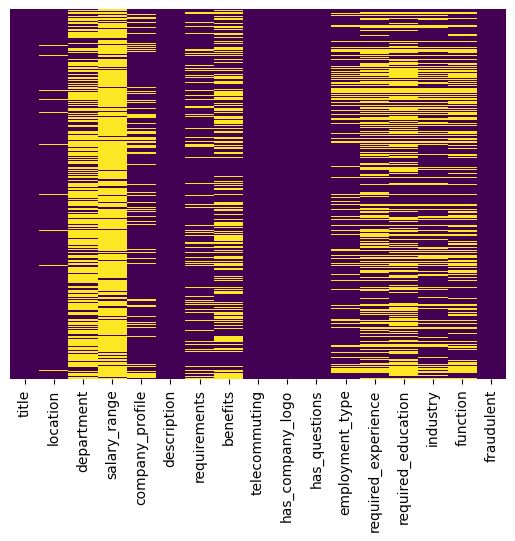

In [ ]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

<ipython-input-13-3416a0dc7d02>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraudulent_counts.index, y=fraudulent_counts.values, palette='rainbow')


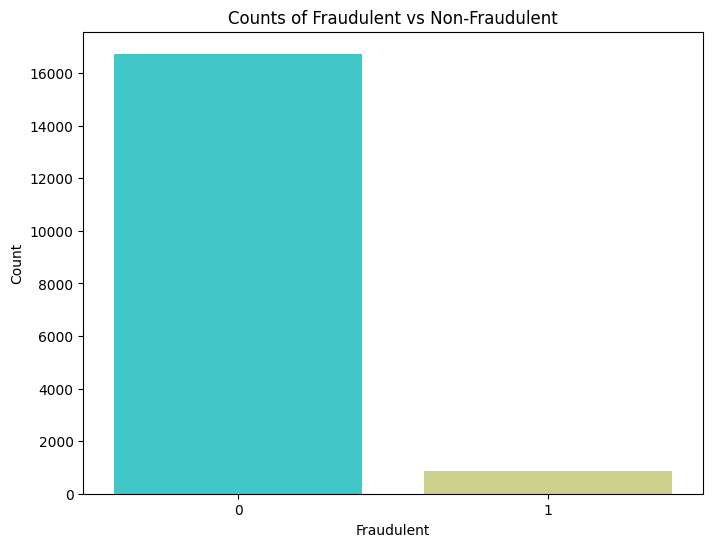

In [ ]:
# Count the occurrences of unique values in the 'fraudulent' column
fraudulent_counts = df['fraudulent'].value_counts()

# Plot the counts using a rainbow color palette
plt.figure(figsize=(8, 6))
sns.barplot(x=fraudulent_counts.index, y=fraudulent_counts.values, palette='rainbow')
plt.xlabel('Fraudulent')
plt.ylabel('Count')
plt.title('Counts of Fraudulent vs Non-Fraudulent')
plt.show()

In [ ]:
# Count the occurrences of unique values in the 'fraudulent' column
print(fraudulent_counts)


fraudulent
0    16743
1      856
Name: count, dtype: int64


<ipython-input-15-e9fe08ea3f28>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=telecommuting_counts.index, y=telecommuting_counts.values, palette='magma')


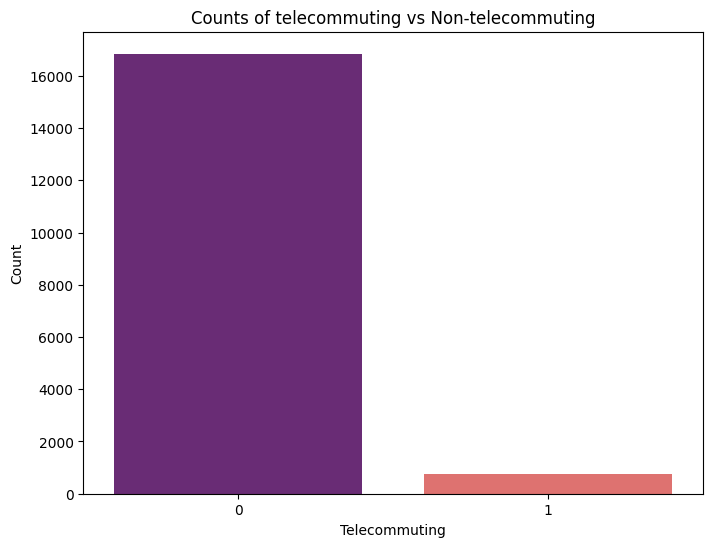

In [ ]:
# Count the occurrences of unique values in the 'telecommuting' column
telecommuting_counts = df['telecommuting'].value_counts()

# Plot the counts using a magma color palette
plt.figure(figsize=(8, 6))
sns.barplot(x=telecommuting_counts.index, y=telecommuting_counts.values, palette='magma')
plt.xlabel('Telecommuting')
plt.ylabel('Count')
plt.title('Counts of telecommuting vs Non-telecommuting')
plt.show()

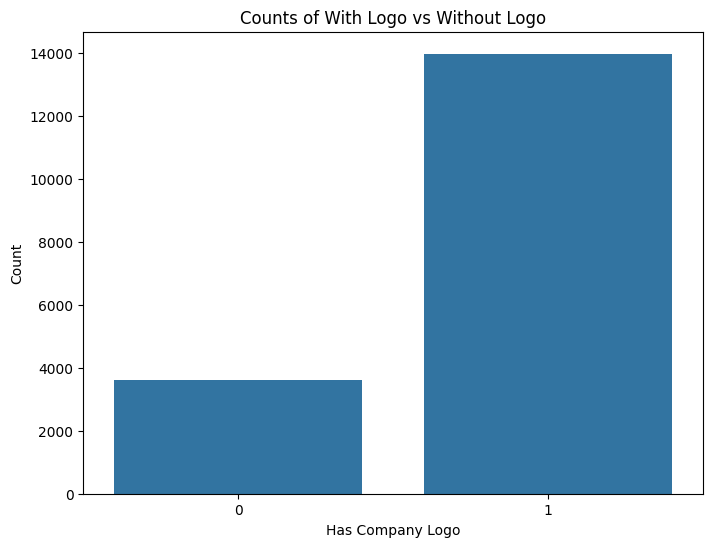

In [ ]:
# Count the occurrences of unique values in the 'has_company_logo' column
has_company_logo_counts = df['has_company_logo'].value_counts()

# Plot the counts
plt.figure(figsize=(8, 6))
sns.barplot(x=has_company_logo_counts.index, y=has_company_logo_counts.values)
plt.xlabel('Has Company Logo')
plt.ylabel('Count')
plt.title('Counts of With Logo vs Without Logo')
plt.show()

<ipython-input-17-a221f1ab7599>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=has_questions_counts.index, y=has_questions_counts.values, palette='cividis')


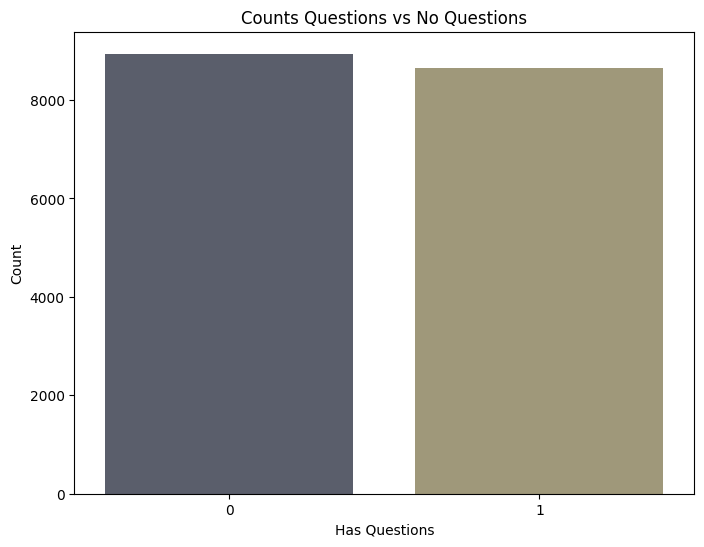

In [ ]:
# Count the occurrences of unique values in the 'has_questions' column
has_questions_counts = df['has_questions'].value_counts()

# Plot the counts
plt.figure(figsize=(8, 6))
sns.barplot(x=has_questions_counts.index, y=has_questions_counts.values, palette='cividis')
plt.xlabel('Has Questions')
plt.ylabel('Count')
plt.title('Counts Questions vs No Questions')
plt.show()

<ipython-input-18-1c9e7ee22b67>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='employment_type', data=df, palette="pastel", order=df['employment_type'].value_counts().index)


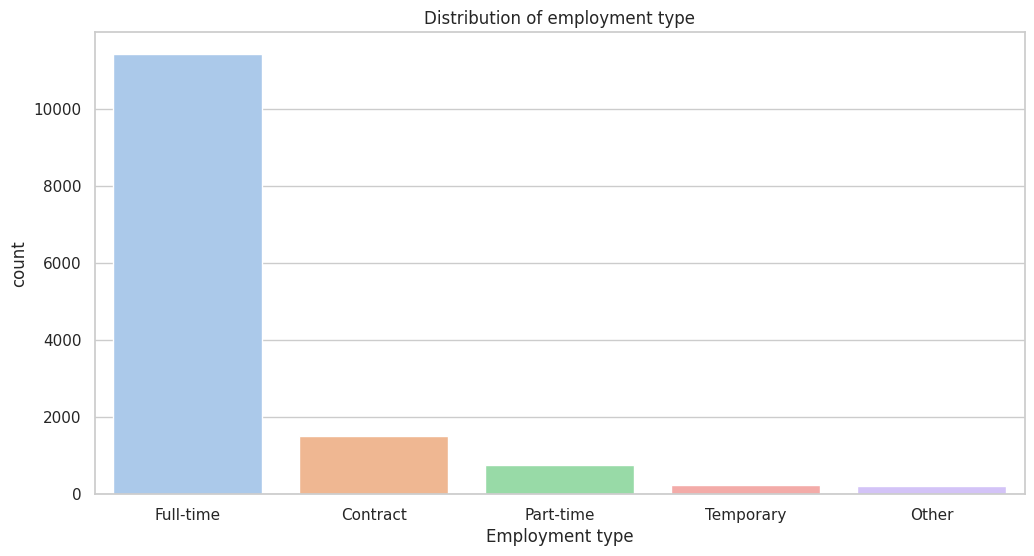

In [ ]:
# visualization of Distribution of employment_type
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

#we use countplot for Distribution of employment_type
sns.countplot(x='employment_type', data=df, palette="pastel", order=df['employment_type'].value_counts().index)
plt.xlabel('Employment type')
plt.title('Distribution of employment type')

plt.show()

<ipython-input-19-5ca0c9587a63>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=required_experience_counts.index, y=required_experience_counts.values, palette='viridis')


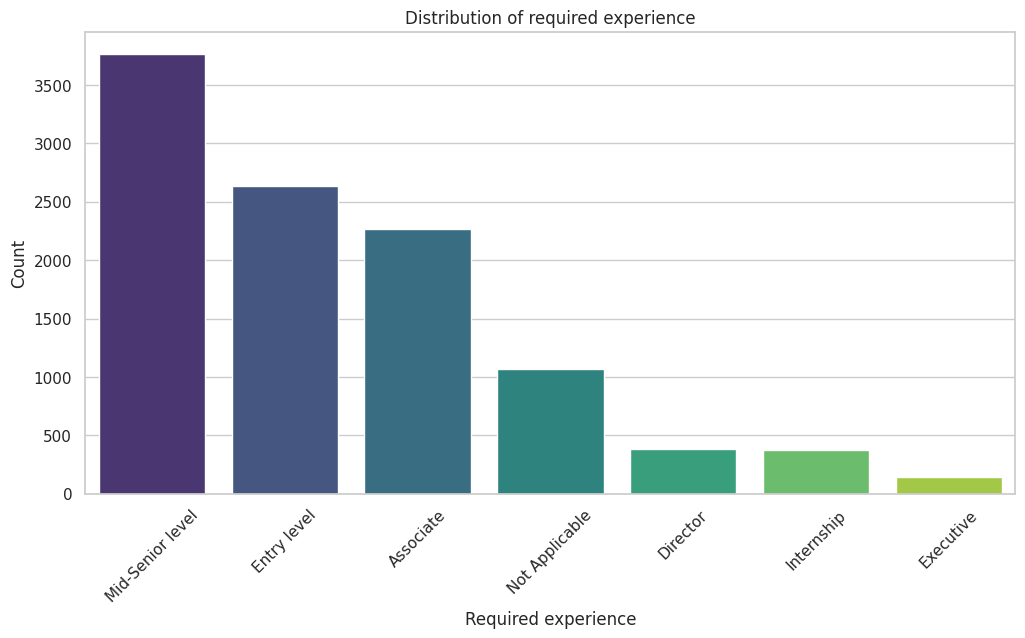

In [ ]:
# Count the occurrences of unique values in the 'has_questions' column
required_experience_counts = df['required_experience'].value_counts()

# Plot the counts
plt.figure(figsize=(12, 6))
sns.barplot(x=required_experience_counts.index, y=required_experience_counts.values, palette='viridis')
plt.xlabel('Required experience')
plt.ylabel('Count')
plt.title('Distribution of required experience')
plt.xticks(rotation=45)
plt.show()

<ipython-input-20-3a569611c4e1>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_20_departments.index, x=top_20_departments.values, palette='magma')


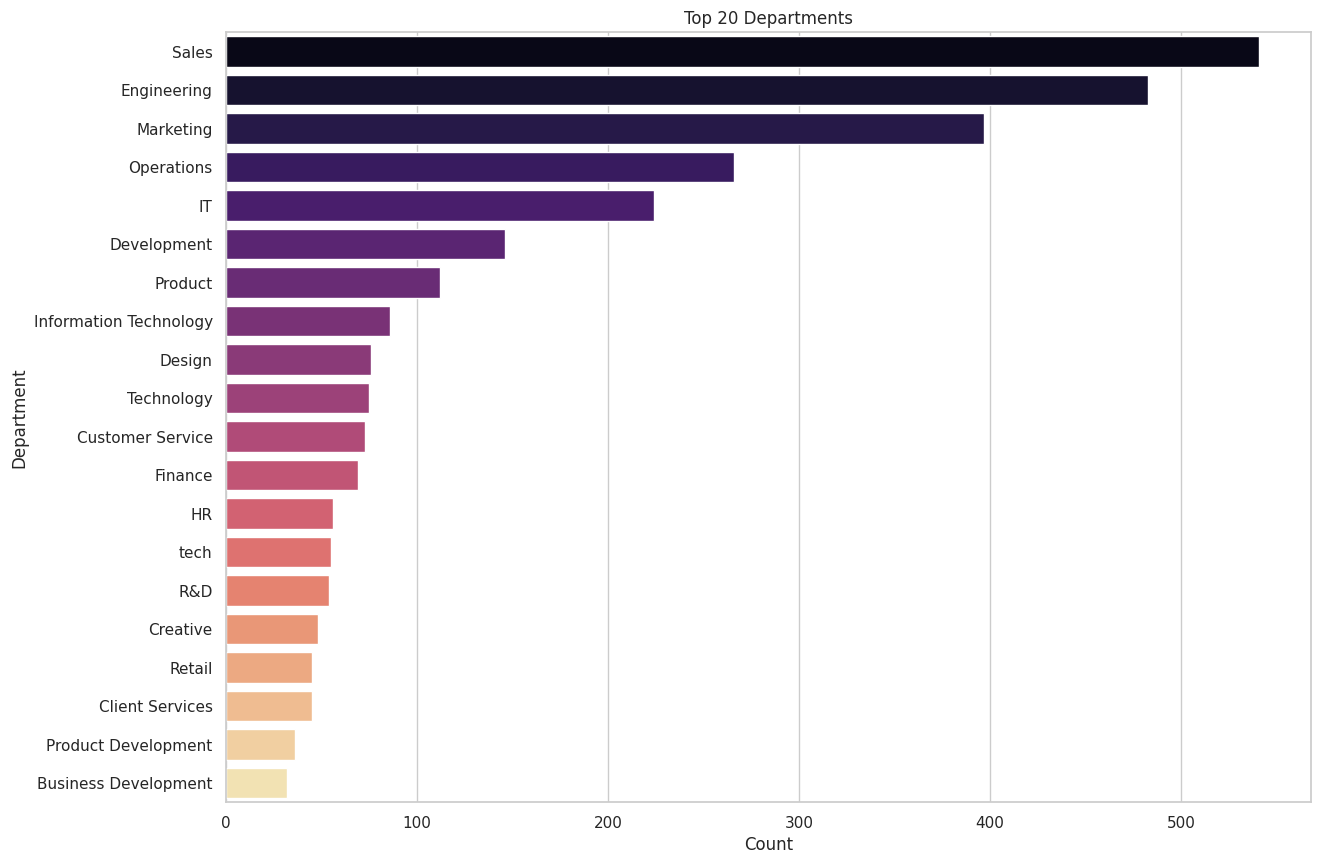

In [ ]:
# Count the occurrences of unique values in the 'department' column
department_counts = df['department'].value_counts()

# Select the top 20 most frequent occurrences
top_20_departments = department_counts.head(20)

# Plot the top 50 most frequent occurrences as horizontal bar plot
plt.figure(figsize=(14, 10))
sns.barplot(y=top_20_departments.index, x=top_20_departments.values, palette='magma')
plt.ylabel('Department')
plt.xlabel('Count')
plt.title('Top 20 Departments')
plt.show()

<ipython-input-21-a369a79b2bda>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_20_industry.index, x=top_20_industry.values, palette='rainbow')


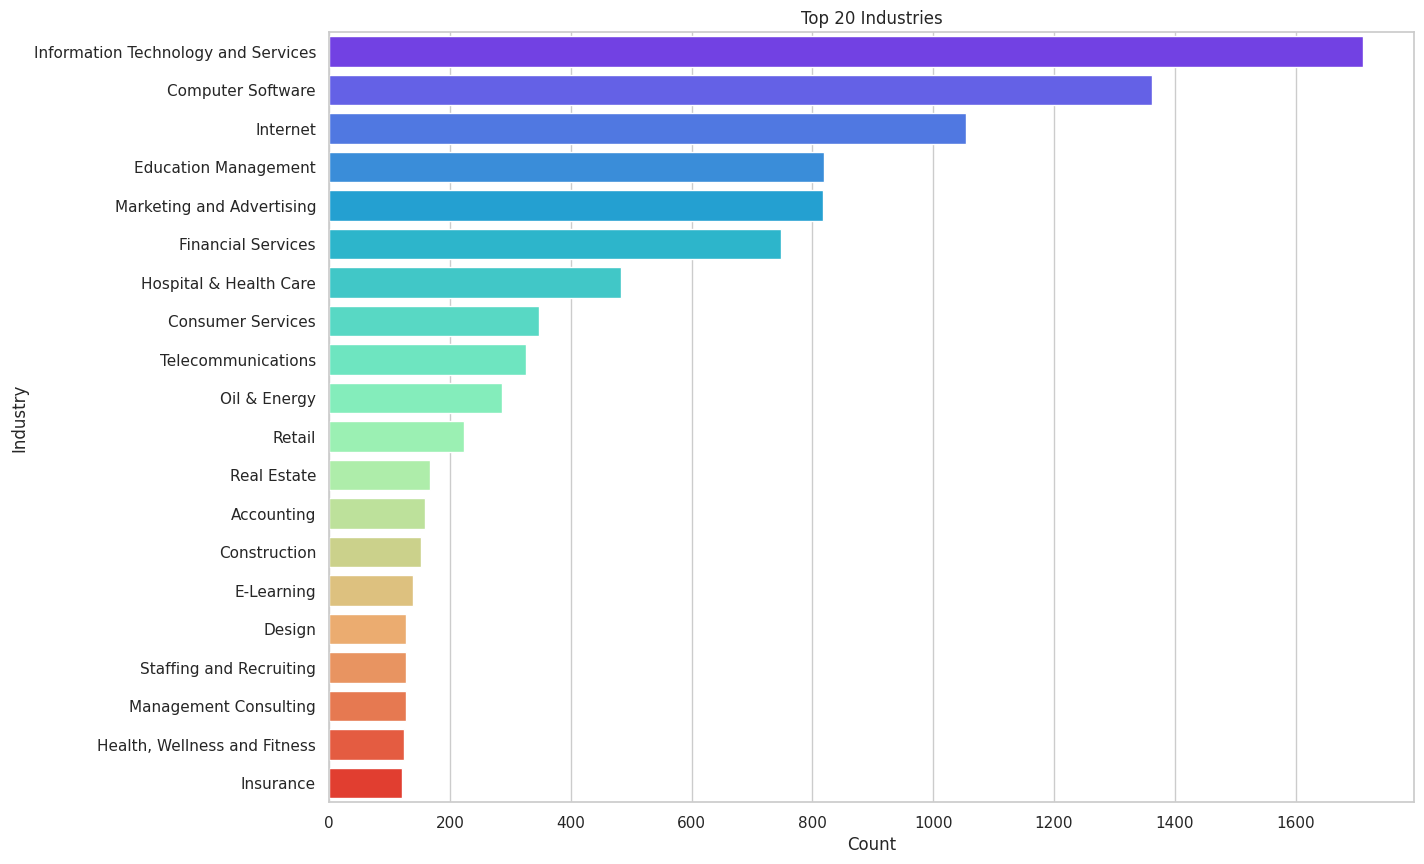

In [ ]:
# Count the occurrences of unique values in the 'industry' column
industry_counts = df['industry'].value_counts()

# Select the top 20 most frequent occurrences
top_20_industry = industry_counts.head(20)

# Plot the top 20 most frequent occurrences as horizontal bar plot with rotated labels
plt.figure(figsize=(14, 10))
sns.barplot(y=top_20_industry.index, x=top_20_industry.values, palette='rainbow')
plt.ylabel('Industry')
plt.xlabel('Count')
plt.title('Top 20 Industries')
plt.show()

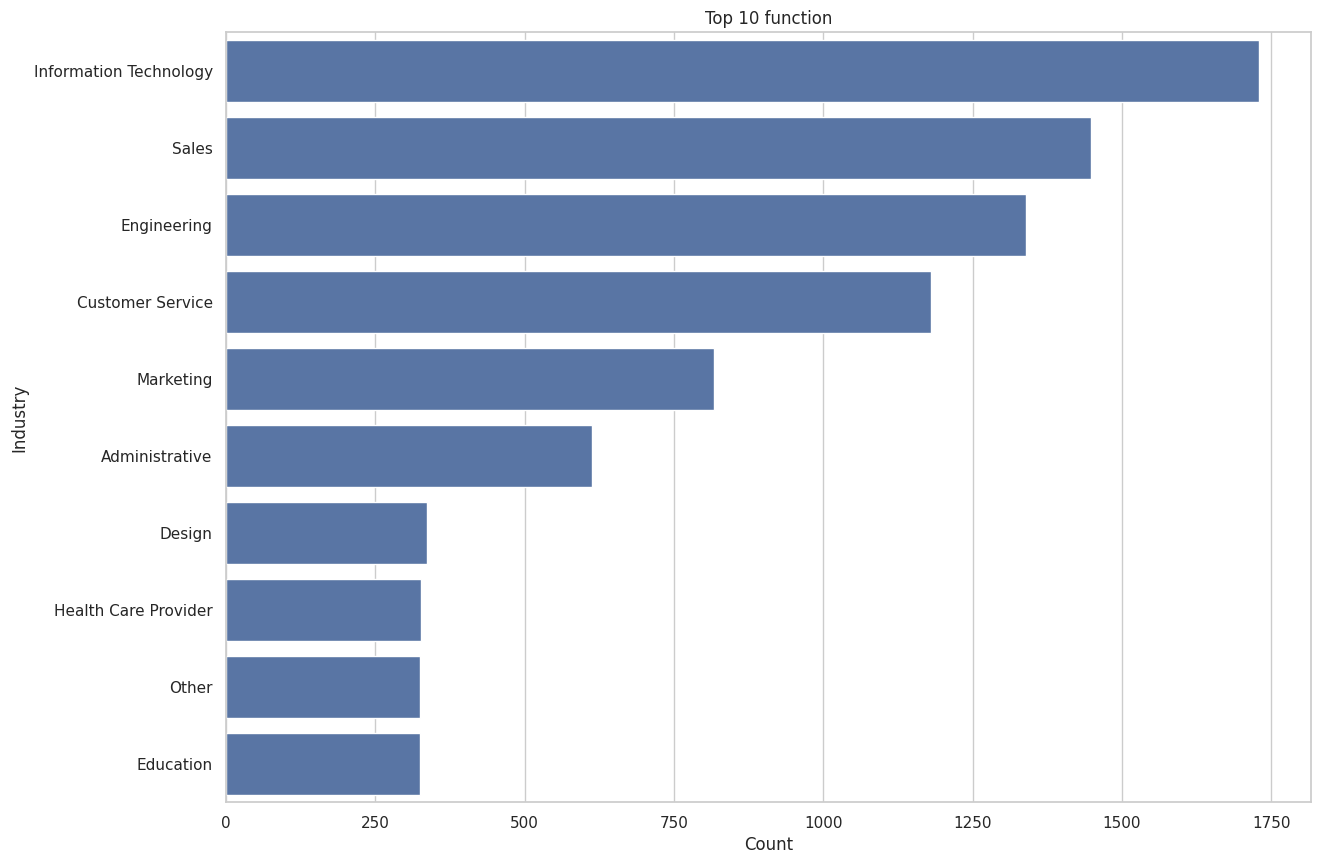

In [ ]:
# Count the occurrences of unique values in the 'function' column
function_counts = df['function'].value_counts()

# Select the top 10 most frequent occurrences
top_10_function = function_counts.head(10)

# Plot the top 10 most frequent occurrences as horizontal bar plot with rotated labels
plt.figure(figsize=(14, 10))
sns.barplot(y=top_10_function.index, x=top_10_function.values)
plt.ylabel('Industry')
plt.xlabel('Count')
plt.title('Top 10 function')
plt.show()

In [ ]:
# Split the 'location' column into separate columns for country, state, and city
location_split = df['location'].str.split(', ', expand=True)
df['Country'] = location_split[0]
df['City'] = location_split[1]

<ipython-input-24-50dd007fdeeb>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_10_Country.index, x=top_10_Country.values, palette='viridis')


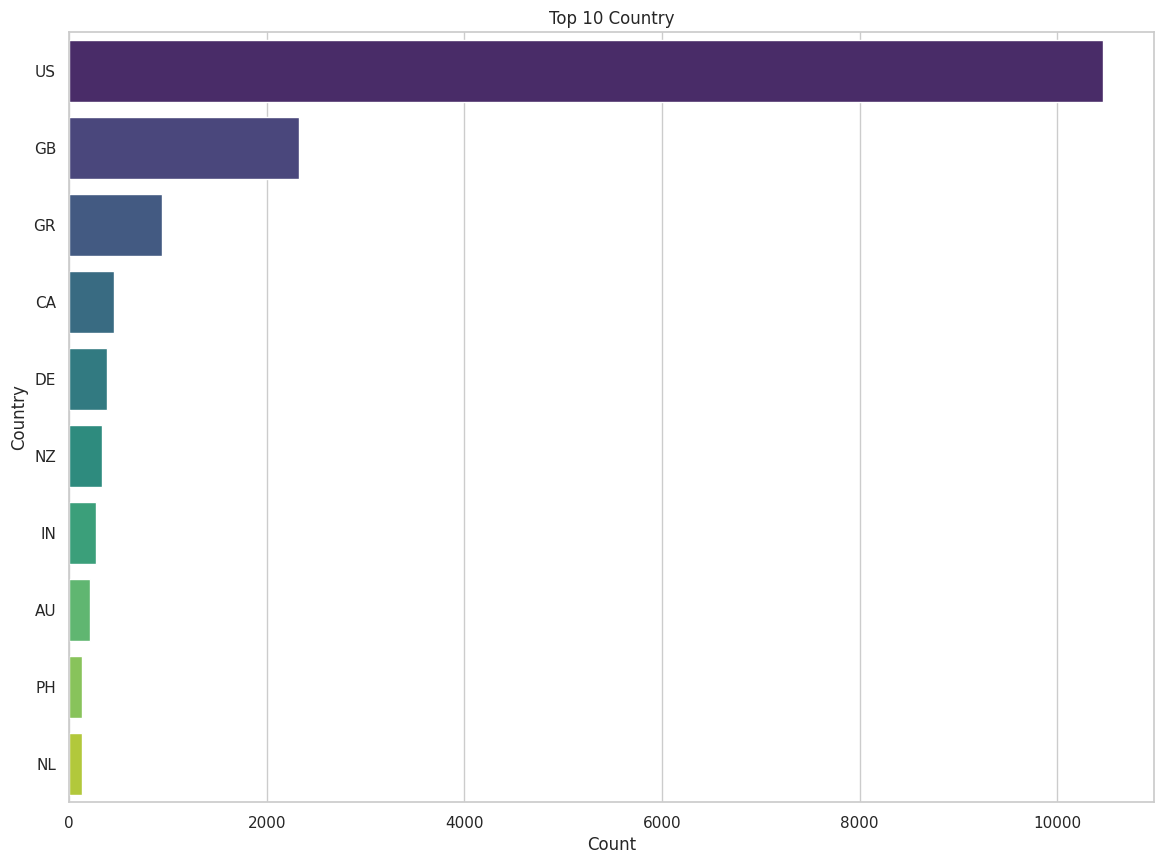

In [ ]:
# Count the occurrences of unique values in the 'Country' column
Country_counts = df['Country'].value_counts()

# Select the top 10 most frequent occurrences
top_10_Country = Country_counts.head(10)

# Plot the top 10 most frequent occurrences as horizontal bar plot with rotated labels
plt.figure(figsize=(14, 10))
sns.barplot(y=top_10_Country.index, x=top_10_Country.values, palette='viridis')
plt.ylabel('Country')
plt.xlabel('Count')
plt.title('Top 10 Country')
plt.show()

In [ ]:
df.isna().sum()

title                      0
location                 341
department             11328
salary_range           14772
company_profile         3282
description                1
requirements            2649
benefits                7108
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3428
required_experience     6962
required_education      8009
industry                4837
function                6363
fraudulent                 0
Country                  341
City                     432
dtype: int64

In [ ]:
df.fillna(" ", inplace=True)

In [ ]:
df.isnull().sum()

title                  0
location               0
department             0
salary_range           0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
Country                0
City                   0
dtype: int64

Suggested

del df['salary_range']
del df['job_id']

In [ ]:
categorical=[]
numerical=[]

for col in df.columns:
    if df[col].dtypes !='object':
            numerical.append(col)
    else:
        categorical.append(col)

<Axes: >

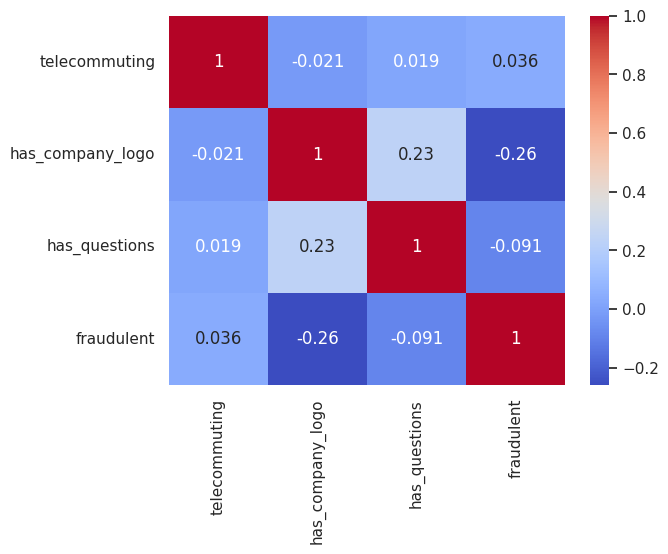

In [ ]:
sns.heatmap(df[numerical].corr(), cmap='coolwarm', annot=True)

df['text'] = df['title'] + ' ' + df['location'] + ' ' + df['department']+ ' ' + df['company_profile'] + ' ' + df['description'] + ' ' + df['requirements'] + ' ' + df['benefits'] + ' ' + df['employment_type'] + ' ' + df['required_experience']+ ' ' + df['required_education'] + ' ' + df['industry'] + ' ' + df['function']:

In [ ]:
df['text'] = df['title'] + ' ' + df['location'] + ' ' + df['department'] + ' ' + df['company_profile'] + ' ' + df['description'] + ' ' + df['requirements'] + ' ' + df['benefits'] + ' ' + df['employment_type'] + ' ' + df['required_experience']+ ' ' + df['required_education'] + ' ' + df['industry'] + ' ' + df['function']

In [ ]:
df.text[1]

"Customer Service - Cloud Video Production NZ, , Auckland Success 90 Seconds, the worlds Cloud Video Production Service.90 Seconds is the worlds Cloud Video Production Service enabling brands and agencies to get high quality online video content shot and produced anywhere in the world. 90 Seconds makes video production fast, affordable, and all managed seamlessly in the cloud from purchase to publish. http://90#URL_fbe6559afac620a3cd2c22281f7b8d0eef56a73e3d9a311e2f1ca13d081dd630#90 Seconds removes the hassle, cost, risk and speed issues of working with regular video production companies by managing every aspect of video projects in a beautiful online experience. With a growing global network of over 2,000 rated video professionals in over 50 countries managed by dedicated production success teams in 5 countries, 90 Seconds provides a 100% success guarantee.90 Seconds has produced almost 4,000 videos in over 30 Countries for over 500 Global brands including some of the worlds largest in

In [ ]:
def cleantext(text):

  # Remove URLs
    text = re.sub(r'https?://\S+|http://\S+|www\.\S+',' ', text)

  # Remove non-printable characters
    text = re.sub(r'[\x00-\x1F\x7F-\x9F]',' ', text)

  # Remove text starting with "URL"
    text = re.sub(r'\bURL\S*',' ', text)

  # Expand contractions
    text = contractions.fix(text)


    text = re.sub(r'<[^.>]+>', '', text)

    text = re.sub(r',', '', text)

    text = re.sub(r'\.', ' ', text)

    # Remove special characters and unknown symbols
    text = re.sub(r'[^a-zA-Z0-9\s]',' ', text)

    # Remove occurrences of '\xa0'
    text = text.replace('\xa0',' ')

    return text

In [ ]:
df.text=df.text.apply(cleantext)

In [ ]:
df.text[1]

'Customer Service   Cloud Video Production NZ  Auckland Success 90 Seconds the worlds Cloud Video Production Service 90 Seconds is the worlds Cloud Video Production Service enabling brands and agencies to get high quality online video content shot and produced anywhere in the world  90 Seconds makes video production fast affordable and all managed seamlessly in the cloud from purchase to publish    Seconds removes the hassle cost risk and speed issues of working with regular video production companies by managing every aspect of video projects in a beautiful online experience  With a growing global network of over 2000 rated video professionals in over 50 countries managed by dedicated production success teams in 5 countries 90 Seconds provides a 100  success guarantee 90 Seconds has produced almost 4000 videos in over 30 Countries for over 500 Global brands including some of the worlds largest including Paypal L Oreal Sony and Barclays and has offices in Auckland London Sydney Tokyo a

In [ ]:
del df['title']
del df['location']
del df['department']
del df['company_profile']
del df['description']
del df['requirements']
del df['benefits']
del df['employment_type']
del df['required_experience']
del df['required_education']
del df['industry']
del df['function']
del df['salary_range']
del df['Country']
del df['City']

In [ ]:
df.head()

,telecommuting,has_company_logo,has_questions,fraudulent,text
0,0,1,0,0,Marketing Intern US NY New York Marketing We a...
1,0,1,0,0,Customer Service Cloud Video Production NZ ...
2,0,1,0,0,Commissioning Machinery Assistant CMA US IA ...
3,0,1,0,0,Account Executive Washington DC US DC Washin...
4,0,1,1,0,Bill Review Manager US FL Fort Worth SpotSou...


In [ ]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

In [ ]:
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [ ]:
def tokenize_text(text):

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stopwords and punctuation
    stop = set(stopwords.words('english')) | set(string.punctuation)
    tokens = [token for token in tokens if token.lower() not in stop]

    # POS tagging
    tagged_tokens = pos_tag(tokens)

    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Lemmatization
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_simple_pos(tag)).lower() for token, tag in tagged_tokens]

    # Rejoin tokens into a string
    return ' '.join(lemmatized_tokens)


In [ ]:
df.text = df.text.apply(tokenize_text)

In [ ]:
df.head()

,telecommuting,has_company_logo,has_questions,fraudulent,text
0,0,1,0,0,marketing intern us ny new york marketing food...
1,0,1,0,0,customer service cloud video production nz auc...
2,0,1,0,0,commissioning machinery assistant cma us ia we...
3,0,1,0,0,account executive washington dc us dc washingt...
4,0,1,1,0,bill review manager us fl fort worth spotsourc...


In [ ]:
df.text[30]

'customer service technical specialist us waltham novitex enterprise solutions formerly pitney bowes management services delivers innovative document communication management solution help company around world drive business process efficiency increase productivity reduce cost improve customer satisfaction almost 30 year client turn u integrate optimize enterprise wide business process empower employee increase productivity maximize result trust partner continually focus deliver secure technology enable document communication solution improve client work process enhance customer interaction drive growth customer service technical specialist base waltham client location right candidate integral part talented team support continue growth responsibilities identify objective data enter key see high level productivity accuracyperform data entry task paper document imageutilize system function perform data look validationperform entry data present structured form correspondence text present 

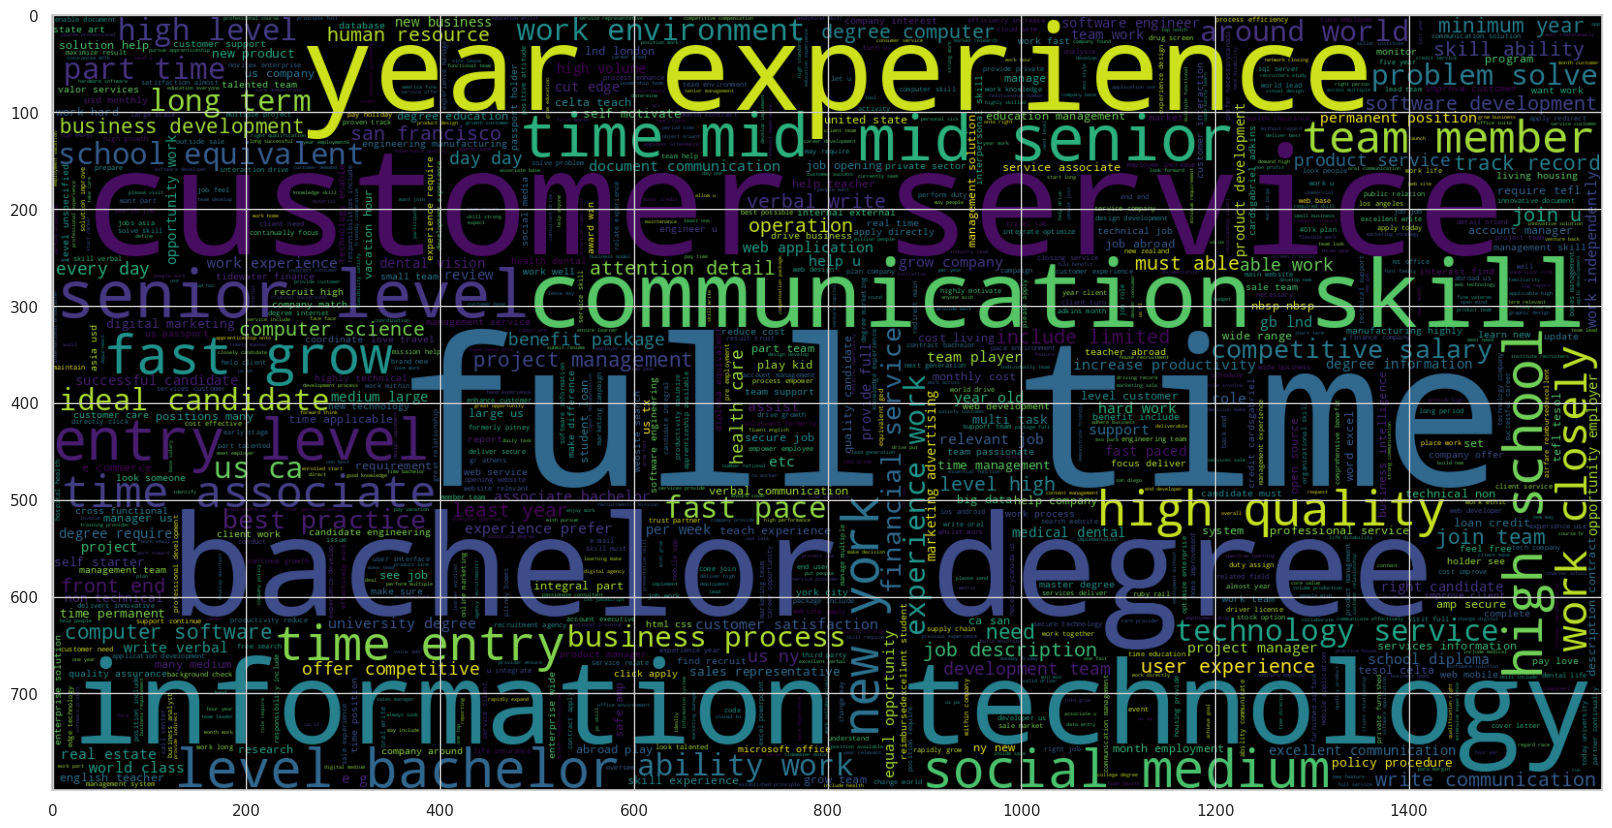

In [ ]:
plt.figure(figsize = (20,20)) # Text that is not fraudulent(0)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.fraudulent == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

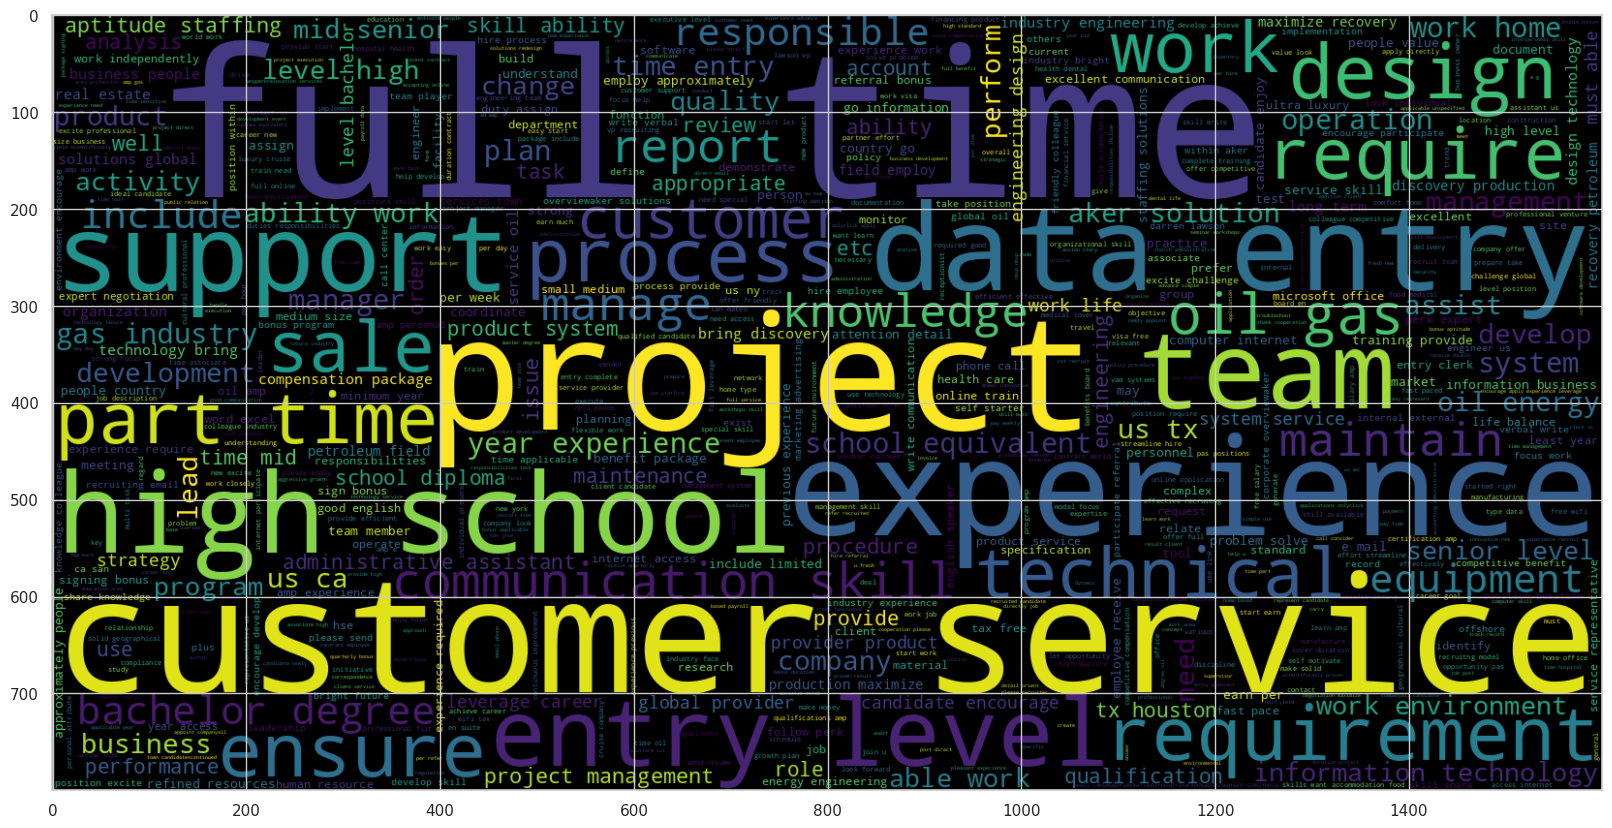

In [ ]:
plt.figure(figsize = (20,20)) # Text that is fraudulent(1)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.fraudulent == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
df.head()

,telecommuting,has_company_logo,has_questions,fraudulent,text
0,0,1,0,0,marketing intern us ny new york marketing food...
1,0,1,0,0,customer service cloud video production nz auc...
2,0,1,0,0,commissioning machinery assistant cma us ia we...
3,0,1,0,0,account executive washington dc us dc washingt...
4,0,1,1,0,bill review manager us fl fort worth spotsourc...


# Model Development

In [ ]:
!pip install imbalanced-learn

# newest model(with telecommuting,	has_company_logo,	has_questions, text as input columns)

In [ ]:
X = df.drop(columns=['fraudulent'])
y = df['fraudulent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
# Define numerical and text columns
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
text_col = 'text'

# Preprocessing for categorical data
categorical_preprocessing = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop="first"))])

# Preprocessing for text data
text_preprocessing = Pipeline(steps=[
    ('tfidf', TfidfVectorizer())])

# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_preprocessing, num_cols),
    ('text', text_preprocessing, text_col)])

# Define models and corresponding parameter grids
models = {
    'RandomForestClassifier': (RandomForestClassifier(), {
        'model__n_estimators': [50, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 10],
        'model__min_samples_leaf': [1, 4]
    }),
    'LogisticRegression': (LogisticRegression(), {
      'model__solver': ['lbfgs', 'saga'],
        'model__penalty': ['l2'],
        'model__C': [1, 10],
        'model__max_iter': [1000, 2000],
        'model__multi_class': ['ovr', 'multinomial', 'auto']
    }),
    'AdaBoostClassifier': (AdaBoostClassifier(), {
        'model__n_estimators': [50, 100],
        'model__learning_rate': [0.01, 0.1]
    }),
    'XGBClassifier': (XGBClassifier(), {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 6]
    })
}
# Define pipeline with resampling technique
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=1)),
    ('model', None)
])

# Perform grid search for each model
for name, (model, param_grid) in models.items():
    print(f"\n{80 * '='}\nPerforming grid search for {name}\n{80 * '='}\n")

    # Set model in pipeline
    pipeline.set_params(model=model)

    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

   # Get the best model and its parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print('Best Model:', name)
    print('Best Parameters:', best_params)

    # Evaluate on test set
    y_pred = best_model.predict(X_test)
    print("\nEvaluation:")
    print(classification_report(y_test, y_pred))



Performing grid search for LogisticRegression

Best Model: LogisticRegression
Best Parameters: {'model__C': 10, 'model__max_iter': 1000, 'model__multi_class': 'multinomial', 'model__penalty': 'l2', 'model__solver': 'lbfgs'}

Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3344
           1       0.86      0.89      0.87       176

    accuracy                           0.99      3520
   macro avg       0.93      0.94      0.93      3520
weighted avg       0.99      0.99      0.99      3520



In [ ]:
import joblib
joblib.dump(best_model, 'model.pkl', compress = 1)
joblib.dump(grid_search, 'pipeline.pkl', compress = 1)

['pipeline.pkl']

In [ ]:
# prompt: use joblib to load pipeline.pkl

pipeline = joblib.load('pipeline.pkl')
pipeline.predict(X_test)[0]


0

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

# Define numerical and text columns
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
text_col = 'text'

# Preprocessing for categorical data
categorical_preprocessing = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop="first"))
])

# Preprocessing for text data
text_preprocessing = Pipeline(steps=[
    ('tfidf', TfidfVectorizer())
])

# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_preprocessing, num_cols),
    ('text', text_preprocessing, text_col)
])

# Define models and corresponding parameter grids
models = {
    'AdaBoostClassifier': (AdaBoostClassifier(), {
        'model__n_estimators': [50, 100],
        'model__learning_rate': [0.01, 0.1]
    }),
    'XGBClassifier': (XGBClassifier(), {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 6]
    })
}

# Define pipeline with resampling technique
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=1)),
    ('model', None)
])

# Perform grid search for each model
for name, (model, param_grid) in models.items():
    print(f"\n{80 * '='}\nPerforming grid search for {name}\n{80 * '='}\n")

    # Set model in pipeline
    pipeline.set_params(model=model)

    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Get the best model and its parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print('Best Model:', name)
    print('Best Parameters:', best_params)

    # Evaluate on test set
    y_pred = best_model.predict(X_test)
    print("\nEvaluation:")
    print(classification_report(y_test, y_pred))


Performing grid search for AdaBoostClassifier

Best Model: AdaBoostClassifier
Best Parameters: {'model__learning_rate': 0.1, 'model__n_estimators': 100}

Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      3344
           1       0.29      0.80      0.43       176

    accuracy                           0.89      3520
   macro avg       0.64      0.85      0.68      3520
weighted avg       0.95      0.89      0.91      3520


Performing grid search for XGBClassifier

Best Model: XGBClassifier
Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 200}

Evaluation:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3344
           1       0.91      0.78      0.84       176

    accuracy                           0.99      3520
   macro avg       0.95      0.89      0.92      3520
weighted avg       0.98      0.99      0.98      3520


# extra model(with SVD method), just for reference

In [ ]:
# Define numerical and text columns
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
text_col = 'text'

# Preprocessing for categorical data
categorical_preprocessing = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop="first"))
])

# Preprocessing for text data
text_preprocessing = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2)))
])

# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_preprocessing, num_cols),
    ('text', text_preprocessing, text_col)
])

# Define models and corresponding parameter grids
models = {
    'RandomForestClassifier': (RandomForestClassifier(), {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    }),
    'LogisticRegression': (LogisticRegression(), {
      'model__solver': ['lbfgs', 'saga'],
        'model__penalty': ['l2'],
        'model__C': [0.1, 1, 10],
        'model__max_iter': [500, 1000, 2000],
        'model__multi_class': ['ovr', 'multinomial', 'auto']
    })
}

# Define pipeline with resampling technique
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=1)),
    ('svd', TruncatedSVD(random_state=1)),
    ('model', None)
])

# Perform grid search for each model
for name, (model, param_grid) in models.items():
    print(f"\n{80 * '='}\nPerforming grid search for {name}\n{80 * '='}\n")

    # Set model in pipeline
    pipeline.set_params(model=model)

    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

   # Get the best model and its parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print('Best Model:', name)
    print('Best Parameters:', best_params)

    # Evaluate on test set
    y_pred = best_model.predict(X_test)
    print("\nEvaluation:")
    print(classification_report(y_test, y_pred))



Performing grid search for RandomForestClassifier

Best Model: RandomForestClassifier
Best Parameters: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 100}

Evaluation:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      3344
           1       0.23      0.69      0.35       176

    accuracy                           0.87      3520
   macro avg       0.61      0.79      0.64      3520
weighted avg       0.94      0.87      0.90      3520


Performing grid search for LogisticRegression

Best Model: LogisticRegression
Best Parameters: {'model__C': 0.1, 'model__max_iter': 500, 'model__multi_class': 'ovr', 'model__penalty': 'l2', 'model__solver': 'lbfgs'}

Evaluation:
              precision    recall  f1-score   support

           0       0.98      0.83      0.90      3344
           1       0.17      0.66      0.27       176

    accuracy                           0.82  

# old model (with only text as input column)

In [ ]:
# Defining a list of tuples with model name and corresponding initialized object
models = [
   ('MultinomialNB', MultinomialNB()),
   ('RandomForestClassifier', RandomForestClassifier())
]

In [ ]:
# Without SMOTE
# Define a dictionary of model parameters for grid search
param_grid = {
    'MultinomialNB': {
        'tfidf__max_features': [5000, 10000],
        'MultinomialNB__alpha': [0.1, 0.5],
        'MultinomialNB__fit_prior': [True, False],
        'MultinomialNB__class_prior': [None, [0.3, 0.7]]
    },
    'RandomForestClassifier': {
        'tfidf__max_features': [5000, 10000],
        'RandomForestClassifier__n_estimators': [50, 200],
        'RandomForestClassifier__max_depth': [None, 10, 20],
        'RandomForestClassifier__min_samples_split': [2, 10],
        'RandomForestClassifier__min_samples_leaf': [1, 4]
    }
}

# Function to create a pipeline, perform grid search, and evaluate each model
def evaluate_models_with_grid_search(models, param_grid, X_train, y_train, X_test, y_test):
    results = {}
    for name, model in models:
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer()),
            (name, model)
        ])

        # Perform grid search
        grid_search = GridSearchCV(pipeline, param_grid[name], cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)

        # Get the best model and its parameters
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        # Evaluate the best model on the test set
        predictions = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        report = classification_report(y_test, predictions)

        results[name] = {
            'best_params': best_params,
            'accuracy': accuracy,
            'report': report
        }

        print(f"Model: {name}")
        print(f"Best Parameters: {best_params}")
        print(f"Accuracy: {accuracy}")
        print(report)
        print("\n")

    return results

# Evaluate all models with grid search
results_with_grid_search = evaluate_models_with_grid_search(models, param_grid, X_train, y_train, X_test, y_test)


In [ ]:
# With SMOTE
# Define a dictionary of model parameters for grid search
param_grid = {
    'MultinomialNB': {
        'tfidf__max_features': [5000, 10000],
        'MultinomialNB__alpha': [0.1, 0.5],
        'MultinomialNB__fit_prior': [True, False],
        'MultinomialNB__class_prior': [None, [0.3, 0.7]]
    },
    'RandomForestClassifier': {
        'tfidf__max_features': [5000, 10000],
        'RandomForestClassifier__n_estimators': [50, 200],
        'RandomForestClassifier__max_depth': [None, 10, 20],
        'RandomForestClassifier__min_samples_split': [2, 10],
        'RandomForestClassifier__min_samples_leaf': [1, 4]
    }
}

# Function to create a pipeline, perform grid search, and evaluate each model
def evaluate_models_with_grid_search(models, param_grid, X_train, y_train, X_test, y_test):
    results = {}
    for name, model in models:
        pipeline = ImbPipeline([
            ('tfidf', TfidfVectorizer()),
            ('smote', SMOTE(random_state=1)),  # Add SMOTE step
            (name, model)
        ])

        # Perform grid search
        grid_search = GridSearchCV(pipeline, param_grid[name], cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)

        # Get the best model and its parameters
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        # Evaluate the best model on the test set
        predictions = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        report = classification_report(y_test, predictions)

        results[name] = {
            'best_params': best_params,
            'accuracy': accuracy,
            'report': report
        }

        print(f"Model: {name}")
        print(f"Best Parameters: {best_params}")
        print(f"Accuracy: {accuracy}")
        print(report)
        print("\n")

    return results

# Evaluate all models with grid search
results_with_grid_search = evaluate_models_with_grid_search(models, param_grid, X_train, y_train, X_test, y_test)


In [ ]:
#Create pipeline
def create_pipeline():
    return Pipeline([
        ('tfidf', TfidfVectorizer(max_df=0.75)),
        ('smote', SMOTE(random_state=1)),
        ('classifier', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', max_depth=5, n_estimators=200))
    ])

pipeline = create_pipeline()

pipeline.fit(X_train, y_train)

# Evaluate the model
prediction = pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, prediction))
print("Classification Report:\n", classification_report(y_test, prediction))

In [ ]:
import pickle

# Assuming you have your pipeline defined earlier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000)),
    ('smote', SMOTE(random_state=1)),
    ('classifier', RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50))
])

# Train pipeline on the entire dataset
pipeline.fit(X, y)

# Output the pipeline to a pickle file
with open('best_model_rf.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

# Deployment

In [ ]:
!pip install -q streamlit
!npm install localtunnel &> '/dev/null'
!wget -O image.png https://wisenetasia.com/wp-content/uploads/2022/10/Job-Scam-Alert-940x423.png -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.3 MB/s eta 0:00:00


In [ ]:
# If cannot run in VSCode, then docker build -t streamlit ./fraud_job_prediction-main

%%writefile app.py

import streamlit as st
import pandas as pd
st.set_page_config(page_title="Fraudulent Job Posting Prediction")

df=pd.read_csv("fake_job_postings.csv")
df = df.drop(columns=['job_id'])
location_split = df['location'].str.split(', ', expand=True)
df['Country'] = location_split[0]
df['City'] = location_split[1]
df.fillna("",inplace=True)

#st.write('Hello, *World!* :sunglasses:')
st.image("image.png")
st.header("Fraudulent Job Posting Prediction")
st.write("Developed by G1 Group 8")

title=st.text_input("Job Title")
desc=st.text_area("Job Description")
profile=st.text_area("Company Profile")
req=st.text_area("Requirements")
benefit=st.text_area("Benefits")
salary=st.text_input("Salary Range")
industry=st.selectbox("Industry",sorted(df.industry.unique()))
dept=st.text_input("Department")#too many values,sorted(df.department.unique()))
function=st.selectbox("Function",sorted(df.function.unique()))
emp_type=st.selectbox("Employment Type",sorted(df.employment_type.unique()))
req_exp=st.selectbox("Required Experience",sorted(df.required_experience.unique()))
req_edu=st.selectbox("Required Education",sorted(df.required_education.unique()))
country=st.selectbox("Country",sorted(df.Country.unique()))
city=st.selectbox("City",sorted(df[df.Country==country].City.unique()))
logo = st.checkbox("Has Company Logo")
telecom = st.checkbox("Telecommuting")
questions = st.checkbox("Has Questions")

submitted = st.button("Submit")
#deploy model
fraud = True
if submitted:
  if not fraud:
    st.success("The job is less likely a fraud.")
  else:
    st.error("The job is likely a fraud!")

Writing app.py


In [ ]:
!streamlit run app.py --server.address=localhost &>/content/logs.txt &
!npx localtunnel --port 8501 & curl ipv4.icanhazip.com

34.34.21.3
npx: installed 22 in 3.468s
your url is: https://open-lies-knock.loca.lt
